In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("/content/Overnight - MIBOR.csv", sep=None, engine="python")


In [3]:
df

,Date,MIBOR(%)
0,21-09-2023,0.0690
1,22-09-2023,0.0691
2,25-09-2023,0.0685
3,26-09-2023,0.0682
4,27-09-2023,0.0684
...,...,...
472,05-09-2025,0.0540
473,09-09-2025,0.0539
474,10-09-2025,0.0539
475,11-09-2025,0.0539


In [4]:
df['Date'] = pd.to_datetime(df['Date'])


/tmp/ipython-input-3386729631.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [5]:
df = df.set_index('Date')

In [6]:
df["Delta r"] = df['MIBOR(%)'].diff()

In [7]:
df = df.dropna()
df

,MIBOR(%),Delta r
Date,,
2023-09-22,0.0691,0.0001
2023-09-25,0.0685,-0.0006
2023-09-26,0.0682,-0.0003
2023-09-27,0.0684,0.0002
2023-09-28,0.0684,0.0000
...,...,...
2025-09-05,0.0540,0.0000
2025-09-09,0.0539,-0.0001
2025-09-10,0.0539,0.0000


In [8]:
dt = 1/252

In [9]:
import numpy as np
from sklearn.linear_model import LinearRegression

The Vasicek model in discrete form is: Δ 𝑟 𝑡 = 𝑎 ( 𝑏 − 𝑟 𝑡 ) Δ 𝑡 + 𝜎 Δ 𝑡 𝜖 𝑡 Δr t ​ =a(b−r t ​ )Δt+σ Δt ​ ϵ t

In [10]:
X = (df['MIBOR(%)'].shift(1).dropna()).values.reshape(-1,1)
Y = df['Delta r'].values[1:]
model = LinearRegression()
model.fit(X, Y)
slope = model.coef_[0]   # slope should be negative
intercept = model.intercept_
print(f"Intercept: {model.intercept_}")
print(f"Coefficient: {model.coef_[0]}")

Intercept: 0.002084318894408406
Coefficient: -0.03282800090347523


In [11]:
slope

np.float64(-0.03282800090347523)

In [12]:
slope = model.coef_[0]
intercept = model.intercept_
a = -slope / dt
b = intercept / (a * dt)
residuals = Y - model.predict(X)
sigma = np.std(residuals) / np.sqrt(dt)
print(f"a (mean reversion speed): {a}")
print(f"b (long-term mean): {b}")
print(f"sigma (volatility): {sigma}")

a (mean reversion speed): 8.272656227675759
b (long-term mean): 0.0634921054296595
sigma (volatility): 0.0207510754165838


In [13]:
df.tail()

,MIBOR(%),Delta r
Date,,
2025-09-05,0.0540,0.0000
2025-09-09,0.0539,-0.0001
2025-09-10,0.0539,0.0000
2025-09-11,0.0539,0.0000
2025-09-12,0.0547,0.0008


In [28]:
a = 0.0827
b = 0.0635
sigma = 0.0020
r0 = 0.0543


In [29]:
years_to_simulate = 6  # simulate up to 6 years so you cover all horizons
total_days_to_simulate = int(years_to_simulate * 252)  # convert years to trading days

T = total_days_to_simulate
rates = np.zeros(T)
rates[0] = r0


In [21]:
for t in range(1, T):
    epsilon = np.random.normal(0,1)
    rates[t] = rates[t-1] + a*(b - rates[t-1])*dt + sigma*np.sqrt(dt)*epsilon


In [22]:
num_simulations = 1000
all_paths = np.zeros((num_simulations, T))

for i in range(num_simulations):
    path = np.zeros(T)
    path[0] = r0
    for t in range(1, T):
        epsilon = np.random.normal(0,1)
        path[t] = path[t-1] + a*(b - path[t-1])*dt + sigma*np.sqrt(dt)*epsilon
    all_paths[i,:] = path


In [23]:
r_3_5y = np.mean(all_paths[:, int(3.5*252)])
r_4_5y = np.mean(all_paths[:, int(4.5*252)])
r_5_5y = np.mean(all_paths[:, int(5.5*252)])



In [24]:
r_3_5y

np.float64(0.056216663830611156)

In [25]:
r_4_5y

np.float64(0.056742907531677704)

In [26]:
r_5_5y

np.float64(0.05729095663586267)

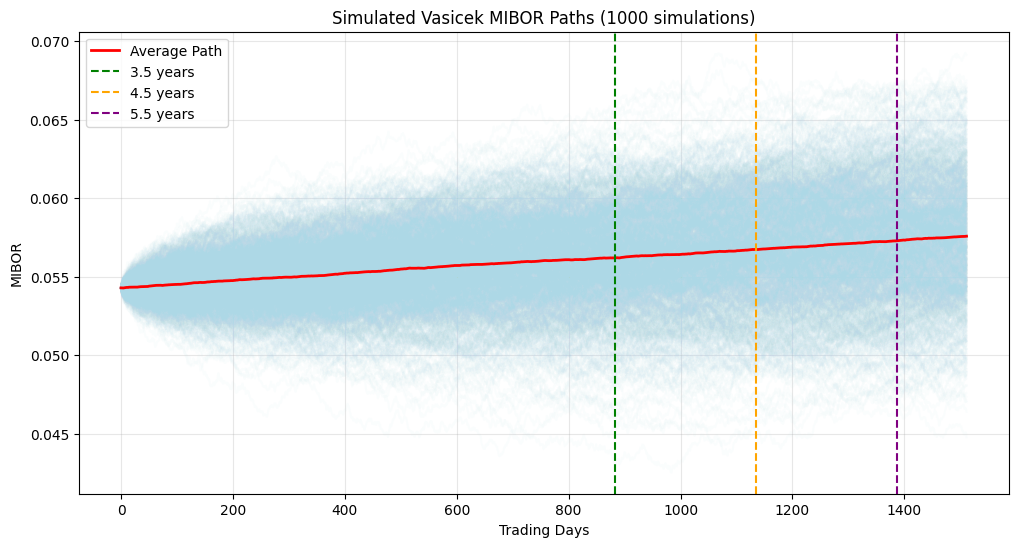

Average MIBOR at 3.5 years: 0.0562 (5.62%)
Average MIBOR at 4.5 years: 0.0567 (5.67%)
Average MIBOR at 5.5 years: 0.0573 (5.73%)


In [27]:
import matplotlib.pyplot as plt

# Calculate average path
avg_path = np.mean(all_paths, axis=0)

# Create single combined plot
plt.figure(figsize=(12,6))

# Plot all simulation paths
for i in range(1000):
    plt.plot(all_paths[i], color='lightblue', alpha=0.05)  # Lower alpha to see better

# Plot average path
plt.plot(avg_path, color='red', linewidth=2, label='Average Path')

# Add vertical lines for different time horizons
plt.axvline(x=int(3.5*252), color='green', linestyle='--', label='3.5 years')
plt.axvline(x=int(4.5*252), color='orange', linestyle='--', label='4.5 years')
plt.axvline(x=int(5.5*252), color='purple', linestyle='--', label='5.5 years')

# Labels and formatting
plt.title("Simulated Vasicek MIBOR Paths (1000 simulations)")
plt.xlabel("Trading Days")
plt.ylabel("MIBOR")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print the average rates at different horizons
print(f"Average MIBOR at 3.5 years: {r_3_5y:.4f} ({r_3_5y*100:.2f}%)")
print(f"Average MIBOR at 4.5 years: {r_4_5y:.4f} ({r_4_5y*100:.2f}%)")
print(f"Average MIBOR at 5.5 years: {r_5_5y:.4f} ({r_5_5y*100:.2f}%)")

In [30]:
maturities = np.array([0,252/2, 252,252*1.5, 252*2, 252*2.5, 252*3, 252*3.5, 252*4,252*4.5, 252*5, 252*5.5,252*6])
zero_rates = np.array([0.0543, 0.0552, 0.056, 0.0568, 0.0567, 0.0583, 0.0591, .0597, 0.0604, .0611, 0.0617, 0.0623, 0.0629 ])

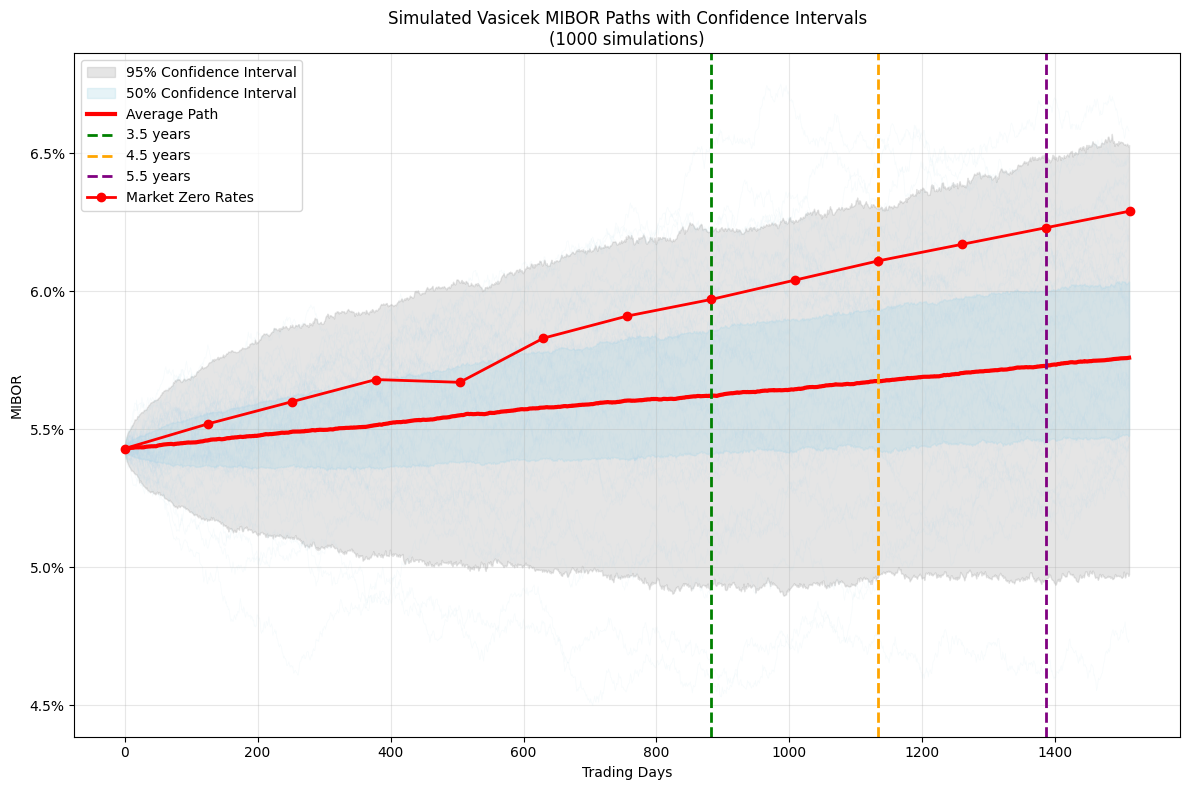


MIBOR at 3.5 years:
  Average: 0.0562 (5.62%)
  95% CI: [0.0493, 0.0622] (4.93% - 6.22%)
  50% CI: [0.0541, 0.0586] (5.41% - 5.86%)

MIBOR at 4.5 years:
  Average: 0.0567 (5.67%)
  95% CI: [0.0497, 0.0630] (4.97% - 6.30%)
  50% CI: [0.0542, 0.0593] (5.42% - 5.93%)

MIBOR at 5.5 years:
  Average: 0.0573 (5.73%)
  95% CI: [0.0496, 0.0647] (4.96% - 6.47%)
  50% CI: [0.0546, 0.0600] (5.46% - 6.00%)


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate confidence intervals
percentile_2_5 = np.percentile(all_paths, 2.5, axis=0)   # Lower 95% CI
percentile_97_5 = np.percentile(all_paths, 97.5, axis=0) # Upper 95% CI
percentile_25 = np.percentile(all_paths, 25, axis=0)     # Lower 50% CI
percentile_75 = np.percentile(all_paths, 75, axis=0)     # Upper 50% CI

# Calculate average path
avg_path = np.mean(all_paths, axis=0)

# Create single combined plot
plt.figure(figsize=(12,8))

# Plot confidence interval bands first (so they appear behind other elements)
plt.fill_between(range(T), percentile_2_5, percentile_97_5,
                 alpha=0.2, color='gray', label='95% Confidence Interval')
plt.fill_between(range(T), percentile_25, percentile_75,
                 alpha=0.3, color='lightblue', label='50% Confidence Interval')

# Plot sample of simulation paths (reduced for clarity)
sample_indices = np.random.choice(1000, 50, replace=False)
for i in sample_indices:
    plt.plot(all_paths[i], color='lightblue', alpha=0.1, linewidth=0.5)

# Plot average path
plt.plot(avg_path, color='red', linewidth=3, label='Average Path')

# Add vertical lines for different time horizons
plt.axvline(x=int(3.5*252), color='green', linestyle='--', linewidth=2, label='3.5 years')
plt.axvline(x=int(4.5*252), color='orange', linestyle='--', linewidth=2, label='4.5 years')
plt.axvline(x=int(5.5*252), color='purple', linestyle='--', linewidth=2, label='5.5 years')

plt.plot(maturities, zero_rates, 'ro-', linewidth=2, markersize=6, label='Market Zero Rates')

# Labels and formatting
plt.title("Simulated Vasicek MIBOR Paths with Confidence Intervals\n(1000 simulations)")
plt.xlabel("Trading Days")
plt.ylabel("MIBOR")
plt.legend()
plt.grid(True, alpha=0.3)

# Format y-axis as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}%'.format(y*100)))

plt.tight_layout()
plt.show()

# Print the average rates at different horizons with confidence intervals
horizons = [3.5, 4.5, 5.5]
horizon_rates = [r_3_5y, r_4_5y, r_5_5y]

for horizon, avg_rate in zip(horizons, horizon_rates):
    day_index = int(horizon * 252)
    rates_at_horizon = all_paths[:, day_index]

    ci_95_lower = np.percentile(rates_at_horizon, 2.5)
    ci_95_upper = np.percentile(rates_at_horizon, 97.5)
    ci_50_lower = np.percentile(rates_at_horizon, 25)
    ci_50_upper = np.percentile(rates_at_horizon, 75)

    print(f"\nMIBOR at {horizon} years:")
    print(f"  Average: {avg_rate:.4f} ({avg_rate*100:.2f}%)")
    print(f"  95% CI: [{ci_95_lower:.4f}, {ci_95_upper:.4f}] ({ci_95_lower*100:.2f}% - {ci_95_upper*100:.2f}%)")
    print(f"  50% CI: [{ci_50_lower:.4f}, {ci_50_upper:.4f}] ({ci_50_lower*100:.2f}% - {ci_50_upper*100:.2f}%)")

In [32]:
maturities = np.array([0,0.5, 1,1.5, 2, 2.5, 3, 3.5, 4,4.5, 5, 5.5,6])

In [33]:
zero_rates = np.array([0.0543, 0.0552, 0.056, 0.0568, 0.0567, 0.0583, 0.0591, .0597, 0.0604, .0611, 0.0617, 0.0623, 0.0629 ])

In [34]:
discount_factors = np.exp(-zero_rates * maturities)

In [35]:
discount_factors

array([1.        , 0.9727774 , 0.94553914, 0.9183286 , 0.89279347,
       0.86437377, 0.83752849, 0.81143581, 0.78537026, 0.7596101 ,
       0.73454795, 0.70988663, 0.68564176])

In [36]:
df = pd.DataFrame({
    "Maturity (yrs)": maturities,
    "Zero Rate": zero_rates,
    "Discount Factor": discount_factors
})

In [37]:
df

,Maturity (yrs),Zero Rate,Discount Factor
0,0.0,0.0543,1.000000
1,0.5,0.0552,0.972777
2,1.0,0.0560,0.945539
3,1.5,0.0568,0.918329
4,2.0,0.0567,0.892793
5,2.5,0.0583,0.864374
6,3.0,0.0591,0.837528
7,3.5,0.0597,0.811436
8,4.0,0.0604,0.785370
9,4.5,0.0611,0.759610


Interpolated rates: [0.0597 0.0611 0.0623]
Discount factors: [0.81143581 0.7596101  0.70988663]


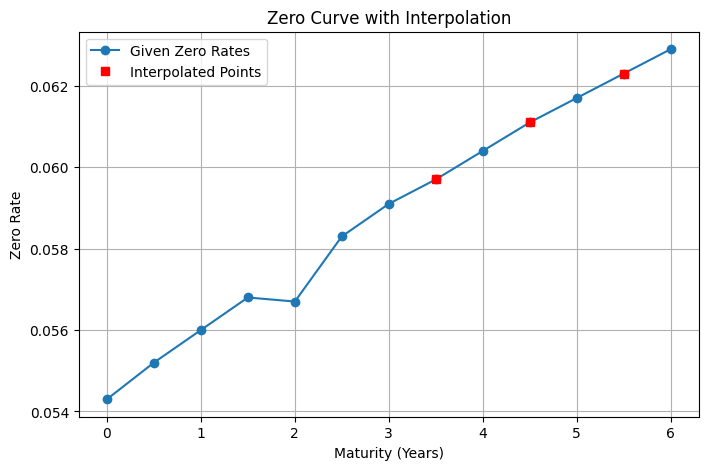

In [38]:
from scipy.interpolate import interp1d

# Interpolator on zero rates
interp = interp1d(maturities, zero_rates, kind="linear", fill_value="extrapolate")

# target maturities
target_T = np.array([3.5, 4.5, 5.5])
target_rates = interp(target_T)

# discount factors for target maturities
target_df = np.exp(-target_rates * target_T)

print("Interpolated rates:", target_rates)
print("Discount factors:", target_df)
plt.figure(figsize=(8,5))
plt.plot(maturities, zero_rates, 'o-', label="Given Zero Rates")
plt.plot(target_T, target_rates, 's', color="red", label="Interpolated Points")
plt.xlabel("Maturity (Years)")
plt.ylabel("Zero Rate")
plt.title("Zero Curve with Interpolation")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
forward_rate = (zero_rates[1:]*maturities[1:]-zero_rates[:-1]*maturities[:-1])/(maturities[1:]-maturities[:-1])
forward_rate = np.insert(forward_rate, 0, np.nan)

In [40]:
forward_rate

array([   nan, 0.0552, 0.0568, 0.0584, 0.0564, 0.0647, 0.0631, 0.0633,
       0.0653, 0.0667, 0.0671, 0.0683, 0.0695])

In [41]:
df = pd.DataFrame({
    "Maturity (yrs)": maturities,
    "Zero Rate": zero_rates,
    "Discount Factor": discount_factors,
    "Forward Rate": forward_rate
})

In [42]:
  df

,Maturity (yrs),Zero Rate,Discount Factor,Forward Rate
0,0.0,0.0543,1.000000,NaN
1,0.5,0.0552,0.972777,0.0552
2,1.0,0.0560,0.945539,0.0568
3,1.5,0.0568,0.918329,0.0584
4,2.0,0.0567,0.892793,0.0564
5,2.5,0.0583,0.864374,0.0647
6,3.0,0.0591,0.837528,0.0631
7,3.5,0.0597,0.811436,0.0633
8,4.0,0.0604,0.785370,0.0653
9,4.5,0.0611,0.759610,0.0667


In [43]:
df_dt = np.zeros_like(forward_rate)
df_dt[1:-1] = (forward_rate[2:] - forward_rate[:-2]) / (maturities[2:] - maturities[:-2])
df_dt[0] = (forward_rate[1] - forward_rate[0]) / (maturities[1] - maturities[0])
df_dt[-1] = (forward_rate[-1] - forward_rate[-2]) / (maturities[-1] - maturities[-2])


In [44]:
a

0.0827

In [45]:
sigma

0.002

In [46]:
# Recalculate theta with new a and sigma
theta = df_dt + a * forward_rate + (sigma**2 / (2 * a)) * (1 - np.exp(-2 * a * maturities))
theta = np.nan_to_num(theta, nan=0.006)

In [47]:
theta

array([0.006     , 0.006     , 0.00790105, 0.00443499, 0.01097109,
       0.01205888, 0.00382783, 0.00744554, 0.00881201, 0.00732878,
       0.00716278, 0.00806286, 0.00816287])

In [48]:
df = pd.DataFrame({
    "Maturity (yrs)": maturities,
    "Zero Rate": zero_rates,
    "Discount Factor": discount_factors,
    "Forward Rate": forward_rate,
    "Theta(t)": theta
})


In [49]:
df

,Maturity (yrs),Zero Rate,Discount Factor,Forward Rate,Theta(t)
0,0.0,0.0543,1.000000,NaN,0.006000
1,0.5,0.0552,0.972777,0.0552,0.006000
2,1.0,0.0560,0.945539,0.0568,0.007901
3,1.5,0.0568,0.918329,0.0584,0.004435
4,2.0,0.0567,0.892793,0.0564,0.010971
5,2.5,0.0583,0.864374,0.0647,0.012059
6,3.0,0.0591,0.837528,0.0631,0.003828
7,3.5,0.0597,0.811436,0.0633,0.007446
8,4.0,0.0604,0.785370,0.0653,0.008812
9,4.5,0.0611,0.759610,0.0667,0.007329


In [50]:
dt = 1  # time step
n_steps = 12  # number of steps (6 years / 0.5)
n_paths = 1000  # number of simulation paths
r0 = 0.0552  # starting rate (your first zero rate)
r = np.zeros((n_paths, n_steps))
r[:, 0] = r0  # all paths start at r0
for i in range(1, n_steps):
    Z = np.random.normal(0, 1, n_paths)  # random shocks
    r[:, i] = r[:, i-1] + (theta[i] - a * r[:, i-1]) * dt + sigma * np.sqrt(dt) * Z

In [52]:
r

array([[0.0552    , 0.05568561, 0.05868511, ..., 0.06763983, 0.07050515,
        0.07154333],
       [0.0552    , 0.05867599, 0.06017065, ..., 0.080234  , 0.08116965,
        0.08310958],
       [0.0552    , 0.05776402, 0.05867748, ..., 0.07957862, 0.07914426,
        0.08114351],
       ...,
       [0.0552    , 0.05388257, 0.05930613, ..., 0.07388357, 0.07727003,
        0.07943269],
       [0.0552    , 0.05944565, 0.06503229, ..., 0.07722827, 0.07486931,
        0.0762842 ],
       [0.0552    , 0.0558298 , 0.06046289, ..., 0.0690658 , 0.06805873,
        0.07191339]])

Done! No more NaN values.
Final average rate: 0.0782


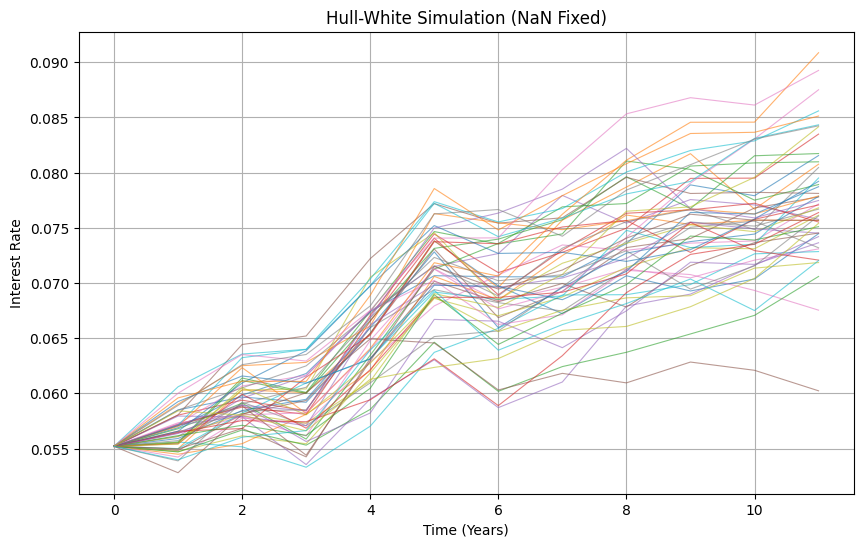

In [53]:
dt = 1  # time step
n_steps = 12  # number of steps
n_paths = 1000  # number of simulation paths
r0 = 0.0552  # starting rate

r = np.zeros((n_paths, n_steps))
r[:, 0] = r0  # all paths start at r0

for i in range(1, n_steps):
    Z = np.random.normal(0, 1, n_paths)  # random shocks
    r[:, i] = r[:, i-1] + (theta[i] - a * r[:, i-1]) * dt + sigma * np.sqrt(dt) * Z

print("Done! No more NaN values.")
print(f"Final average rate: {np.mean(r[:, -1]):.4f}")

# Plot it
import matplotlib.pyplot as plt

time_grid = np.arange(0, n_steps) * dt

plt.figure(figsize=(10, 6))
for i in range(50):
    plt.plot(time_grid, r[i], alpha=0.6, linewidth=0.8)

plt.xlabel('Time (Years)')
plt.ylabel('Interest Rate')
plt.title('Hull-White Simulation (NaN Fixed)')
plt.grid(True)
plt.show()

Done! No more NaN values.
Final average rate: 0.0703


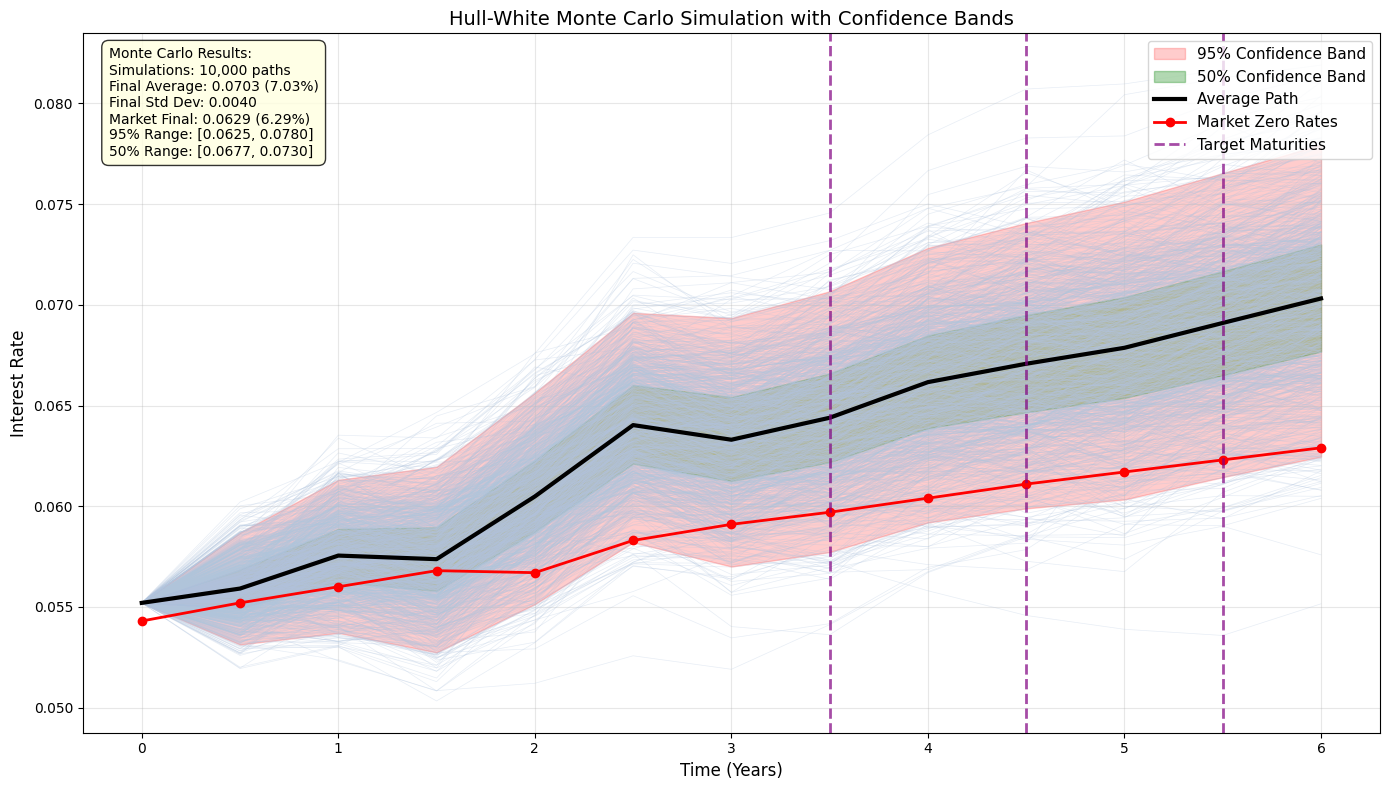


HULL-WHITE MONTE CARLO SIMULATION RESULTS
Number of simulations: 10,000
Time horizon: 6 years
Starting rate: 0.0552 (5.52%)


In [54]:
dt = 0.5  # time step
n_steps = 13  # number of steps
n_paths = 10000  # number of simulation paths
r0 = 0.0552  # starting rate

r = np.zeros((n_paths, n_steps))
r[:, 0] = r0  # all paths start at r0

for i in range(1, n_steps):
    Z = np.random.normal(0, 1, n_paths)  # random shocks
    r[:, i] = r[:, i-1] + (theta[i] - a * r[:, i-1]) * dt + sigma * np.sqrt(dt) * Z

print("Done! No more NaN values.")
print(f"Final average rate: {np.mean(r[:, -1]):.4f}")

# Enhanced Plot with Confidence Bands
import matplotlib.pyplot as plt
import numpy as np

time_grid = np.arange(0, n_steps) * dt

# Calculate statistics at each time point
mean_path = np.mean(r, axis=0)
std_path = np.std(r, axis=0)

# Calculate confidence intervals
confidence_50_lower = np.percentile(r, 25, axis=0)  # 25th percentile
confidence_50_upper = np.percentile(r, 75, axis=0)  # 75th percentile
confidence_95_lower = np.percentile(r, 2.5, axis=0)  # 2.5th percentile
confidence_95_upper = np.percentile(r, 97.5, axis=0)  # 97.5th percentile

plt.figure(figsize=(14, 8))

# Plot many simulation paths (light blue, same color as Monte Carlo)
for i in range(1000):  # Plot 100 paths for better visualization
    plt.plot(time_grid, r[i], alpha=0.3, linewidth=0.5, color='lightsteelblue')

# 95% Confidence Band (lightest)
plt.fill_between(time_grid, confidence_95_lower, confidence_95_upper,
                 alpha=0.2, color='red', label='95% Confidence Band')

# 50% Confidence Band (darker)
plt.fill_between(time_grid, confidence_50_lower, confidence_50_upper,
                 alpha=0.3, color='green', label='50% Confidence Band')

# Average line (thick black)
plt.plot(time_grid, mean_path, 'k-', linewidth=3, label='Average Path')

# Market zero rates for comparison
plt.plot(maturities, zero_rates, 'ro-', linewidth=2, markersize=6, label='Market Zero Rates')

# Add vertical lines at 3.5, 4.5, and 5.5 years
plt.axvline(x=3.5, color='purple', linestyle='--', linewidth=2, alpha=0.7, label='Target Maturities')
plt.axvline(x=4.5, color='purple', linestyle='--', linewidth=2, alpha=0.7)
plt.axvline(x=5.5, color='purple', linestyle='--', linewidth=2, alpha=0.7)

plt.xlabel('Time (Years)', fontsize=12)
plt.ylabel('Interest Rate', fontsize=12)
plt.title('Hull-White Monte Carlo Simulation with Confidence Bands', fontsize=14)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)


# Add summary statistics box
final_avg = mean_path[-1]
final_std = std_path[-1]
market_final = zero_rates[-1]

stats_text = f'''Monte Carlo Results:
Simulations: {n_paths:,} paths
Final Average: {final_avg:.4f} ({final_avg*100:.2f}%)
Final Std Dev: {final_std:.4f}
Market Final: {market_final:.4f} ({market_final*100:.2f}%)
95% Range: [{confidence_95_lower[-1]:.4f}, {confidence_95_upper[-1]:.4f}]
50% Range: [{confidence_50_lower[-1]:.4f}, {confidence_50_upper[-1]:.4f}]'''

plt.text(0.02, 0.98, stats_text,
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*60)
print("HULL-WHITE MONTE CARLO SIMULATION RESULTS")
print("="*60)
print(f"Number of simulations: {n_paths:,}")
print(f"Time horizon: {time_grid[-1]:.0f} years")
print(f"Starting rate: {r0:.4f} ({r0*100:.2f}%)")


In [55]:
import numpy as np
import pandas as pd

# Extract values at 0.5-year intervals from 0.5 to 6 years
maturity_points = np.arange(0.5, 6.5, 0.5)  # 0.5, 1.0, 1.5, ..., 6.0
print("Maturity points:", maturity_points)

# Initialize arrays to store the values
avg_line_values = []
market_zero_values = []

# Get average line values (Monte Carlo mean path)
for maturity in maturity_points:
    # Find the closest time point in our simulation grid
    closest_idx = np.argmin(np.abs(time_grid - maturity))
    closest_time = time_grid[closest_idx]
    avg_value = mean_path[closest_idx]
    avg_line_values.append(avg_value)

# Get market zero rate values by interpolation
# Assuming maturities and zero_rates are available from previous code
market_zero_interp = np.interp(maturity_points, maturities, zero_rates)
market_zero_values = market_zero_interp.tolist()

# Create a comprehensive table
results_df = pd.DataFrame({
    'Maturity (Years)': maturity_points,
    'Average Line (Decimal)': avg_line_values,
    'Average Line (%)': [val * 100 for val in avg_line_values],
    'Market Zero Rate (Decimal)': market_zero_values,
    'Market Zero Rate (%)': [val * 100 for val in market_zero_values],
    'Difference (bps)': [(avg - mkt) * 10000 for avg, mkt in zip(avg_line_values, market_zero_values)]
})

# Display the table
print("\n" + "="*90)
print("MATURITY-WISE COMPARISON: AVERAGE LINE vs MARKET ZERO RATES")
print("="*90)
print(results_df.to_string(index=False, float_format='{:.4f}'.format))

Maturity points: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6. ]

MATURITY-WISE COMPARISON: AVERAGE LINE vs MARKET ZERO RATES
 Maturity (Years)  Average Line (Decimal)  Average Line (%)  Market Zero Rate (Decimal)  Market Zero Rate (%)  Difference (bps)
           0.5000                  0.0559            5.5911                      0.0552                5.5200            7.1082
           1.0000                  0.0575            5.7549                      0.0560                5.6000           15.4899
           1.5000                  0.0574            5.7370                      0.0568                5.6800            5.7016
           2.0000                  0.0605            6.0484                      0.0567                5.6700           37.8409
           2.5000                  0.0640            6.4029                      0.0583                5.8300           57.2866
           3.0000                  0.0633            6.3302                      0.0591                5

In [56]:
results_df.describe()

,Maturity (Years),Average Line (Decimal),Average Line (%),Market Zero Rate (Decimal),Market Zero Rate (%),Difference (bps)
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,3.250000,0.063630,6.362994,0.059183,5.918333,44.466033
std,1.802776,0.004837,0.483701,0.002592,0.259224,23.542939
min,0.500000,0.055911,5.591082,0.055200,5.520000,5.701574
25%,1.875000,0.059750,5.975031,0.056775,5.677500,32.253143
50%,3.250000,0.064211,6.421106,0.059400,5.940000,52.110647
75%,4.625000,0.067273,6.727301,0.061250,6.125000,60.230053
max,6.000000,0.070316,7.031571,0.062900,6.290000,74.157067


In [57]:

market_rates = np.array([0.0543, 0.0552, 0.056, 0.0568, 0.0567, 0.0583, 0.0591, .0597, 0.0604, .0611, 0.0617, 0.0623, 0.0629])   # market zeros
model_rates  = np.array([0.0552, 0.0564, 0.0580, 0.0578, 0.0610, 0.0644, 0.0637, 0.0648, 0.0665, 0.0674, 0.0682,0.0694,0.0706] )  # model zeros

# RMSE calculation
rmse = np.sqrt(np.mean((model_rates - market_rates)**2))
print("RMSE:", rmse)


RMSE: 0.00510633091217318


In [59]:

market_rates = np.array([0.0543, 0.0552, 0.056, 0.0568, 0.0567, 0.0583, 0.0591, .0597, 0.0604, .0611, 0.0617, 0.0623, 0.0629])   # market zeros
model_rates  = np.array([0.0552, 0.0548, 0.0549, 0.055, 0.0556, 0.0558, 0.056, 0.0561, 0.0563, 0.0565, 0.0567,0.0568,0.0569] )  # model zeros

# RMSE calculation
rmse = np.sqrt(np.mean((model_rates - market_rates)**2))
print("RMSE:", rmse)


RMSE: 0.003559062106359353
